# 1. Set Up Notebook and Load Data 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import fnmatch
import pickle
import ipywidgets as widgets
from IPython.display import display
import sys
import os
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Input, Flatten, Dense, Conv2DTranspose, LeakyReLU, BatchNormalization,  LeakyReLU,  Activation, LSTM, TimeDistributed, RepeatVector, Lambda, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import elu
from tensorflow.keras.initializers import HeUniform, GlorotUniform, HeNormal, LecunNormal
from tensorflow.keras import regularizers



# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[1],description='Set :',disabled=False); set_widget

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.0


Dropdown(description='Set :', index=1, options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='All')

In [30]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*24*16*minmax*')]
# input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*16*minmax*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist3D-Full-nE16-nt24-ndt16-normminmax.pkl',), value='hist3D-Ful…

In [31]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
# Data
df_label = df_properties.copy()
df_label_h = df_label[['obsreg_id','hard_hs', 'hard_hm','hard_ms']]
df_label_v = df_label[['obsreg_id','var_prob_b','var_prob_h','var_prob_m','var_prob_s']]
df_label_i = df_label[['obsreg_id','var_index_b']]
mask_nonan_h = df_label_h.notna().all(axis=1)
mask_nonan_v = df_label_v.notna().all(axis=1)
mask_nonan_i = df_label_i.notna().all(axis=1)
index_nonan_h = list(df_label_h.notna().all(axis=1).index[df_label_h.notna().all(axis=1)])
index_nonan_v = list(df_label_v.notna().all(axis=1).index[df_label_v.notna().all(axis=1)])
index_nonan_i = list(df_label_i.notna().all(axis=1).index[df_label_i.notna().all(axis=1)])
df_label_h = df_label_h[mask_nonan_h]
df_label_v = df_label_v[mask_nonan_v]
df_label_i = df_label_i[mask_nonan_i]

hr_hs = np.array(df_label_h['hard_hs'].values)
hr_hm = np.array(df_label_h['hard_hm'].values)
hr_ms = np.array(df_label_h['hard_ms'].values)

var_b = np.array(df_label_v['var_prob_b'].values)
var_h = np.array(df_label_v['var_prob_h'].values)
var_m = np.array(df_label_v['var_prob_m'].values)
var_s = np.array(df_label_v['var_prob_s'].values)

var_index = np.array(df_label_i['var_index_b'].values)

yh = np.vstack((hr_hs, hr_hm, hr_ms)).T
desc_h = ['HR HS', 'HR HM', 'HR MS']
yv = np.vstack((var_b, var_h, var_m, var_s)).T
desc_v = ['VAR B', 'VAR H', 'VAR M', 'VAR S']

yi = np.array([1 if value >= 5 else 0 for value in var_index])

In [32]:
prop_option = ['HR', 'VAR', 'VAR_INDEX']

prop_widget = widgets.Dropdown(options=prop_option[:],value=prop_option[0],description='Property:',disabled=False); prop_widget

Dropdown(description='Property:', options=('HR', 'VAR', 'VAR_INDEX'), value='HR')

In [56]:
prop = prop_widget.value

if prop == 'HR':
    y = yh
    dfp = df_label_h
    X = np.array([features[i].flatten() for i in index_nonan_h])
    npred = 3
    desc = desc_h
    active = 'tanh'
    ymin = -1
elif prop == 'VAR':
    y = yv
    dfp = df_label_v
    X = np.array([features[i].flatten() for i in index_nonan_v])
    npred = 4
    desc = desc_v
    active = 'sigmoid'
    ymin = 0
elif prop == 'VAR_INDEX':
    y = yi
    dfp = df_label_i
    X = np.array([features[i].flatten() for i in index_nonan_i])
    npred = 1
    active = 'sigmoid'
    ymin = 0

ID = dfp['obsreg_id'].values
rs = 505
splits = 0.1
X_train, X_test, ID_train, ID_test, y_train, y_test = train_test_split(X, ID, y, test_size=splits, random_state=rs)
# Print Summary
print ('Training Set X', X_train.shape)
print ('Test Set X', X_test.shape)
print ('Training Set Y', y_train.shape)
print ('Test Set Y', y_test.shape)
print(X[0].shape, y[0].shape)

Training Set X (55413, 6144)
Test Set X (6157, 6144)
Training Set Y (55413, 4)
Test Set Y (6157, 4)
(6144,) (4,)


# 3. Predictor Model

In [57]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Create an MLP regressor with one hidden layer of 100 neurons
mlp = MLPRegressor(hidden_layer_sizes=(120,120,120), activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init = 0.001, batch_size=1024, max_iter=1000, random_state=42,early_stopping=True, tol=0.0000001, alpha = 0.001, n_iter_no_change=25, validation_fraction=0.2, verbose = False)
# mlp = MLPRegressor(hidden_layer_sizes=(120,120,120), activation='relu', solver='adam', learning_rate = 'adaptive', learning_rate_init = 0.001, batch_size=1024, max_iter=1000, random_state=42,early_stopping=True, tol=0.0000001, alpha = 0.001, n_iter_no_change=25, validation_fraction=0.2, verbose = False) #HR
# mlp = MLPRegressor(hidden_layer_sizes=(120,120,120), activation='relu', solver='adam', random_state=42,early_stopping=False,  max_iter=25)
# mlp = MLPRegressor(hidden_layer_sizes=(2048,512,126,32), activation='relu', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, batch_size=1024, max_iter=1000, random_state=42, early_stopping=True, tol=0.0000001, alpha=0.0001, n_iter_no_change=25, validation_fraction=0.2, verbose=False)
mlp.out_activation_ = active

# Train the model on the training data
mlp.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.04163262608765747


In [58]:
y_pred = np.clip(mlp.predict(X_test),ymin,1)
mse_b = mean_squared_error(y_test[:,0], y_pred[:,0])
mse_h = mean_squared_error(y_test[:,1], y_pred[:,1])
mse_m = mean_squared_error(y_test[:,2], y_pred[:,2])
mse_s = mean_squared_error(y_test[:,3], y_pred[:,3])

y_pred = mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error overall:", mse)

print("Mean Squared Error:", mse_b)
print("Mean Squared Error:", mse_h)
print("Mean Squared Error:", mse_m)
print("Mean Squared Error:", mse_s)

Mean Squared Error overall: 0.04163262608765747
Mean Squared Error: 0.04786078831173367
Mean Squared Error: 0.0426590897383253
Mean Squared Error: 0.040412264780835365
Mean Squared Error: 0.03498479922573133


In [44]:
# y_pred = np.clip(model.predict(X_test),y_min,1)
input_widget_1 = widgets.Dropdown(options=desc[:],value=desc[0],description='Feature :',disabled=False,style = {'description_width': 'initial'}); input_widget_1

Dropdown(description='Feature :', options=('VAR B', 'VAR H', 'VAR M', 'VAR S'), style=DescriptionStyle(descrip…

MSE for {input_widget_1.value}:  0.03503028376266582
MSE overall:  0.04163262608765747


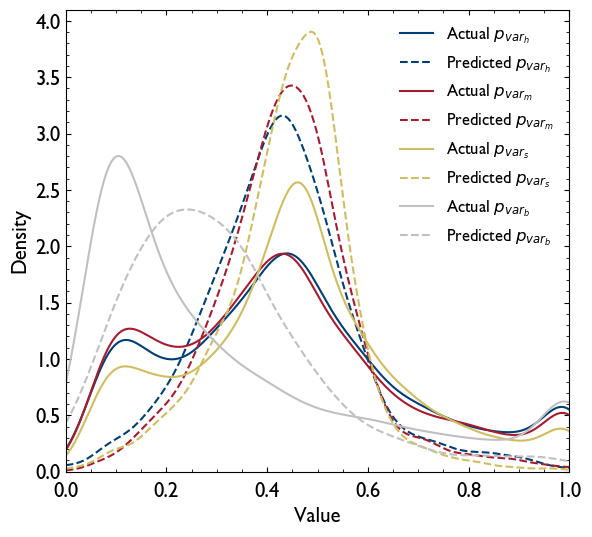

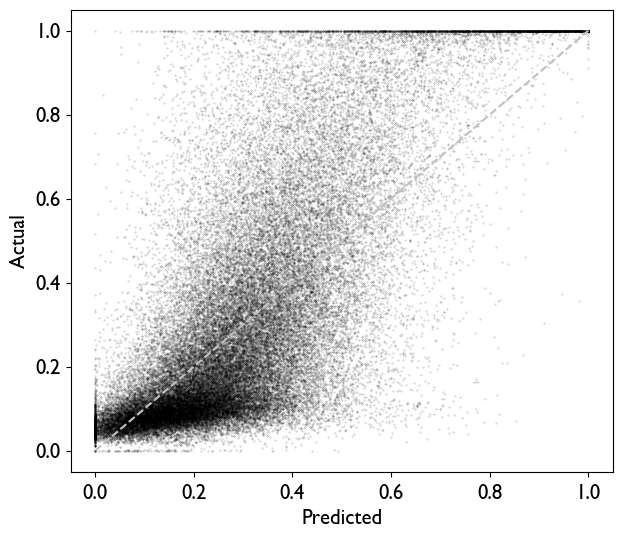

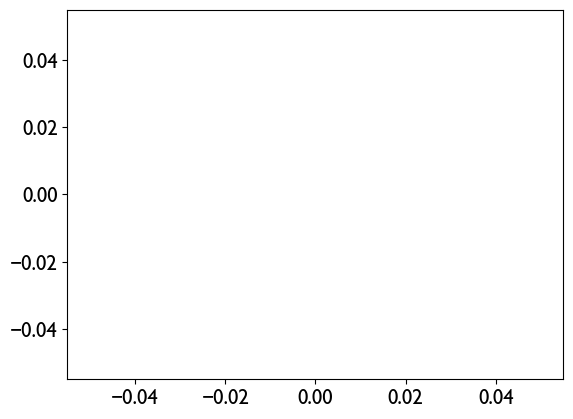

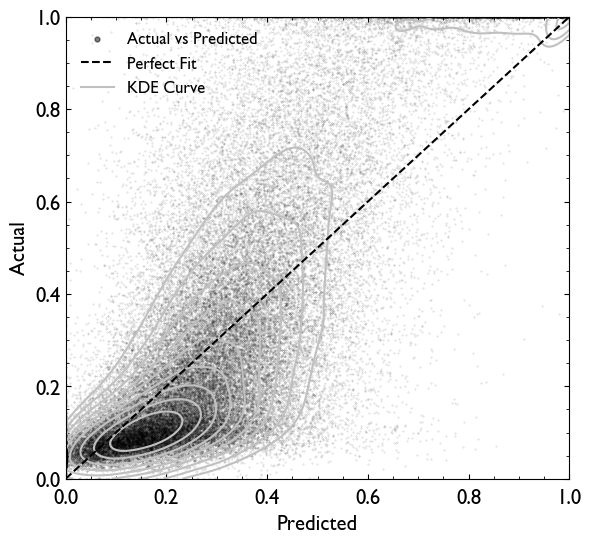

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'

# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
font2 = 12

c = desc.index(input_widget_1.value)
y_test_c = y_test[:,c]
y_pred_c = y_pred[:,c]

y_pred_full = np.clip(mlp.predict(X),ymin,1)
y_test_c = y[:,c]
y_pred_c = y_pred_full[:,c]

mse_c = mean_squared_error(y_test_c, y_pred_c)
mse = mean_squared_error(y_test, y_pred)
print('MSE for {input_widget_1.value}: ', mse_c)
print('MSE overall: ', mse)

# #1
# fig, axs = plt.subplots(figsize=(6.5, 6))
# sns.kdeplot(y_test[:,1], label=r'Actual $HR_{hm}$', linestyle = '-',color=imperial, clip = [ymin,1])
# sns.kdeplot(y_pred[:,1], label=r'Predicted $HR_{hm}$', linestyle = '--',color=imperial, clip = [ymin,1])
# sns.kdeplot(y_test[:,0], label=r'Actual $HR_{hs}$', linestyle = '-',color=harvard, clip = [ymin,1])
# sns.kdeplot(y_pred[:,0], label=r'Predicted $HR_{hs}$', linestyle = '--',color=harvard, clip = [ymin,1])
# sns.kdeplot(y_test[:,2], label=r'Actual $HR_{ms}$', linestyle = '-',color=gold, clip = [ymin,1])
# sns.kdeplot(y_pred[:,2], label=r'Predicted $HR_{ms}$', linestyle = '--',color=gold, clip = [ymin,1])
# plt.xlabel('Value')
# plt.ylabel('Density')
# axs.minorticks_on()
# axs.tick_params(which='both', direction='in', top=True, right=True)
# plt.legend(loc='upper right', frameon=False, fontsize = font2)
# axs.set_xlim([ymin,1])
# plt.tick_params(axis='x', pad=7)
# plt.show()

#1
fig, axs = plt.subplots(figsize=(6.5, 6))
sns.kdeplot(y_test[:,1], label=r'Actual $p_{var_h}$', linestyle = '-',color=imperial, clip = [ymin,1])
sns.kdeplot(y_pred[:,1], label=r'Predicted $p_{var_h}$', linestyle = '--',color=imperial, clip = [ymin,1])
sns.kdeplot(y_test[:,2], label=r'Actual $p_{var_m}$', linestyle = '-',color=harvard, clip = [ymin,1])
sns.kdeplot(y_pred[:,2], label=r'Predicted $p_{var_m}$', linestyle = '--',color=harvard, clip = [ymin,1])
sns.kdeplot(y_test[:,3], label=r'Actual $p_{var_s}$', linestyle = '-',color=gold, clip = [ymin,1])
sns.kdeplot(y_pred[:,3], label=r'Predicted $p_{var_s}$', linestyle = '--',color=gold, clip = [ymin,1])
sns.kdeplot(y_test[:,0], label=r'Actual $p_{var_b}$', linestyle = '-',color=silver2, clip = [ymin,1])
sns.kdeplot(y_pred[:,0], label=r'Predicted $p_{var_b}$', linestyle = '--',color=silver2, clip = [ymin,1])
plt.xlabel('Value')
plt.ylabel('Density')
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
plt.legend(loc='upper right', frameon=False, fontsize = font2)
axs.set_xlim([ymin,1])
plt.tick_params(axis='x', pad=7)
plt.show()


#2

# Create a scatter plot with the predicted values on the x-axis and the actual values on the y-axis
fig, axs = plt.subplots(figsize=(7, 6))
plt.scatter(y_pred_c, y_test_c, s=0.1,color='black', alpha = 0.3)
# sns.kdeplot(x=y_pred_c, y=y_test_c,fill=0, thresh=0.25,legend=True, color = 'red')
plt.plot([y_pred_c.min(), y_pred_c.max()], [y_pred_c.min(), y_pred_c.max()], linestyle = '--', color = silver2)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tick_params(axis='x', pad=5)
plt.show()



col = silver2
custom_markers = [plt.scatter([], [], marker='.', color='black', alpha = 0.5,edgecolor='black', s=50),
                  plt.Line2D([], [], linestyle='--',color='black'),
                  plt.Line2D([], [], linestyle='-', color=col)]
# Create a scatter plot with the predicted values on the x-axis and the actual values on the y-axis
fig, axs = plt.subplots(figsize=(6.5, 6))
plt.scatter(y_pred_c, y_test_c, s=0.1,color='black', alpha = 0.2, label = 'Actual vs Predicted')
sns.kdeplot(x=y_pred_c, y=y_test_c,fill=0, thresh=0.2,legend=True, color = col, label = 'KDE', clip = [ymin,1])
plt.plot([y_pred_c.min(), y_pred_c.max()], [y_pred_c.min(), y_pred_c.max()], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
plt.legend(handles=custom_markers, labels=['Actual vs Predicted', 'Perfect Fit', 'KDE Curve'], loc='upper left', frameon=False, fontsize = font2)
plt.tick_params(axis='x', pad=7)
plt.show()



# 4. Classifier

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score

# Create an MLP classifier with one hidden layer of 100 neurons
mlp = MLPClassifier(hidden_layer_sizes=(126,64,32,16), activation='relu', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, batch_size=1024, max_iter=1000, random_state=42, early_stopping=True, tol=0.0000001, alpha=0.0001, n_iter_no_change=25, validation_fraction=0.2, verbose=False)
# mlp = MLPClassifier(hidden_layer_sizes=(512,126,64,32), activation='relu', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, batch_size=1024, max_iter=1000, random_state=42, early_stopping=True, tol=0.0000001, alpha=0.0001, n_iter_no_change=25, validation_fraction=0.2, verbose=False)
# mlp = MLPClassifier(hidden_layer_sizes=(2048,512,126,32), activation='relu', solver='adam', learning_rate='adaptive', learning_rate_init=0.001, batch_size=1024, max_iter=1000, random_state=42, early_stopping=True, tol=0.0000001, alpha=0.0001, n_iter_no_change=25, validation_fraction=0.2, verbose=False)
# Train the model on the training data
mlp.fit(X_train, y_train)

# Evaluate the model on the testing data
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.9306449910271297


In [336]:
print(y_pred)

[0 0 0 ... 0 0 0]


In [14]:
import matplotlib.colors as mcolors
import seaborn as sns
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'

# Create a dictionary that maps values between 0 and 1 to colors
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
# Create the colormap using the dictionary and the two colors
cmap_h = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white', gold, harvard,'black'], N=256)
cmap_h2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',harvard,'black'], N=256)
cmap_h3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [gold, harvard,'black'], N=256)
# Create the colormap using the dictionary and the two colors
cmap_ic = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',silver2,imperial,'black'], N=256)
cmap_ic2 = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',imperial,'black'], N=256)
cmap_ic3 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [silver2,imperial,'black'], N=256)

cmapsilver = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',silver2,'black'], N=256)

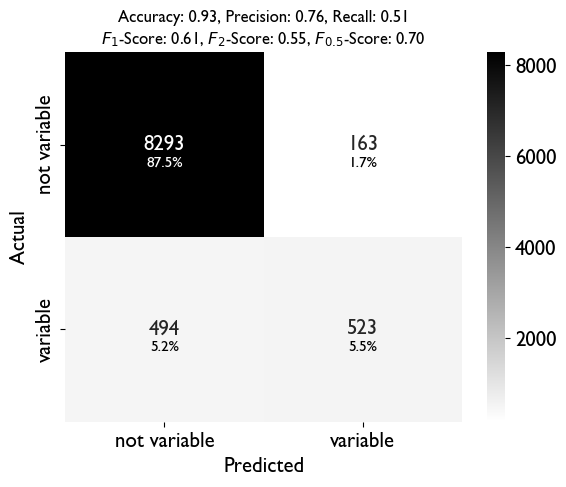

Accuracy: 0.9306449910271297
Precision: 0.7623906705539358
Recall: 0.5142576204523107
$F_1$: 0.6142102172636524
F2: 0.5500631047538915
F0.5: 0.6952938048391385


In [53]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Calculate the F1 score
yy = mlp.predict(X_test)
f1 = f1_score(y_test, yy)

# Create a confusion matrix
cm = confusion_matrix(y_test, yy)
cm_percent = cm / cm.sum() * 100

# Calculate precision
precision = precision_score(y_test, yy)

# Calculate recall
recall = recall_score(y_test, yy)

# Calculate accuracy
accuracy = accuracy_score(y_test, yy)

# Calculate F2 score
f2 = fbeta_score(y_test, yy, beta=2)

# Calculate F0.5 score
f05 = fbeta_score(y_test, yy, beta=0.5)


# Plot the confusion matrix
labels = ['not variable', 'variable']
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
sns.heatmap(cm, annot=True, cmap='binary', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Accuracy: {:.2f}'.format(accuracy) + ', ' + 'Precision: {:.2f}'.format(precision) + ', ' + 'Recall: {:.2f}'.format(recall) + '\n' + r'$F_1$' + '-Score: {:.2f}'.format(f1) + ', ' + r'$F_2$' + '-Score: {:.2f}'.format(f2) + ', ' + r'$F_{0.5}$' + '-Score: {:.2f}'.format(f05), fontsize = 12)
          
# Add percentage values to the annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.6, '{:.1f}%'.format(cm_percent[i, j]), ha='center', va='center', fontsize=11)
plt.text(0 + 0.5, 0 + 0.6, '{:.1f}%'.format(cm_percent[0, 0]), ha='center', va='center', fontsize=11, color = 'white')
plt.show()



print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(r"$F_1$:", f1)
print("F2:", f2)
print("F0.5:", f05)


In [50]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Calculate the F1 score
yy = mlp.predict(X_test)
f1 = f1_score(yi, yy)

# Create a confusion matrix
cm = confusion_matrix(yi, yy)
cm_percent = cm / cm.sum() * 100

# Calculate precision
precision = precision_score(yi, yy)

# Calculate recall
recall = recall_score(yi, yy)

# Calculate accuracy
accuracy = accuracy_score(yi, yy)

# Calculate F2 score
f2 = fbeta_score(yi, yy, beta=2)

# Calculate F0.5 score
f05 = fbeta_score(yi, yy, beta=0.5)


# Plot the confusion matrix
labels = ['not variable', 'variable']
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
sns.heatmap(cm, annot=True, cmap='binary', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Accuracy: {:.2f}'.format(accuracy) + ', ' + 'Precision: {:.2f}'.format(precision) + ', ' + 'Recall: {:.2f}'.format(recall) + '\n' + r'$F_1$' + '-Score: {:.2f}'.format(f1) + ', ' + r'$F_2$' + '-Score: {:.2f}'.format(f2) + ', ' + r'$F_{0.5}$' + '-Score: {:.2f}'.format(f05), fontsize = 12)
          
# Add percentage values to the annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.6, '{:.1f}%'.format(cm_percent[i, j]), ha='center', va='center', fontsize=11)
plt.text(0 + 0.5, 0 + 0.6, '{:.1f}%'.format(cm_percent[0, 0]), ha='center', va='center', fontsize=11, color = 'white')
plt.show()



print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(r"$F_1$:", f1)
print("F2:", f2)
print("F0.5:", f05)


ValueError: Found input variables with inconsistent numbers of samples: [94729, 9473]